<a href="https://colab.research.google.com/github/djbell01/563-DawsonBell/blob/main/MC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [ ]:
def autocorr1D(array):
    ft = np.fft.rfft(array - np.average(array))
    acorr = np.fft.irfft(ft * np.conjugate(ft)) / (len(array) * np.var(array))
    decorr_time = np.where(acorr<0)[0][0]
    return len(array) // decorr_time

class Particle():
  def __init__(self,position):
    self.position = np.array(position)

class System():
  def __init__(self,N,L,sigma):
    self.N = N
    self.L = L
    self.sigma = sigma

    self.particles = []
    for i in range(self.N):
      position = np.random.uniform(-self.L/2,self.L/2,3)
      self.particles.append(Particle(position))

    # Check and resolve overlaps
    for i in range(self.N):
        overlap = True
        while overlap:
            overlap = False
            for j in range(i):  # Only check previous particles
                distance = self.minimum_image_distance(self.particles[i].position, self.particles[j].position)
                if distance < self.sigma:  # Overlap detected
                    self.particles[i].position = np.random.uniform(0, self.L, 3)
                    overlap = True
                    break  # Restart check for this particle

    self.energy = self.calculate_energy()

  def minimum_image_distance(self,pos1,pos2):
    diff_vector = pos1 - pos2
    diff_vector = (diff_vector+(self.L/2))%self.L-(self.L/2)
    return np.linalg.norm(diff_vector)

  def calculate_energy(self):
    energy = 0
    for i in range(len(self.particles)):
      for j in range(len(self.particles)):
        if i < j:
          distance = self.minimum_image_distance(self.particles[i].position,self.particles[j].position)
          epsilon = 1.0
          energy += 4*epsilon*((self.sigma/distance)**12 - (self.sigma/distance)**6)
    self.energy = energy
    return energy

  def plot_positions(self):
    positions = [self.particles[i].position for i in range(self.N)]
    positions = np.array(positions)
    x,y,z = positions.T

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x,y,z)
    lim = self.L/2
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
    ax.set_zlim(-lim,lim)
    return ax

class Dynamics():
  def __init__(self,N,L,sigma,nsteps,temperature):
    self.system = System(N,L,sigma)
    self.nsteps = nsteps
    self.T = temperature
    self.energies = []
    self.per_particle_energies = []

  def run_dynamics(self):
    self.accepted = 0
    self.rejected = 0
    for i in range(self.nsteps):
      new_system = copy.deepcopy(self.system)
      rand_particle_index = np.random.randint(0,new_system.N)
      random_movement = np.random.uniform(-new_system.sigma,new_system.sigma)
      random_direction = np.random.randint(3) # 0=x, 1=y, 2=z
      new_system.particles[rand_particle_index].position[random_direction] = new_system.particles[rand_particle_index].position[random_direction] + random_movement
      if np.abs(new_system.particles[rand_particle_index].position[random_direction]) >= new_system.L/2:
        new_system.particles[rand_particle_index].position[random_direction] = (new_system.particles[rand_particle_index].position[random_direction]+(new_system.L/2))%new_system.L-(new_system.L/2)


      new_energy = new_system.calculate_energy()
      delta_E = new_energy - self.system.energy
      if delta_E < 0:
        self.system = new_system
        self.energies.append(new_energy)
        self.accepted += 1
      elif delta_E >= 0:
        boltzmann_factor = np.exp(-delta_E/self.T)
        rand = np.random.random()
        if rand <= boltzmann_factor:
          self.system = new_system
          self.energies.append(new_energy)
          self.accepted += 1
        elif rand > boltzmann_factor:
          self.energies.append(self.system.energy)
          self.rejected += 1
    self.per_particle_energies = np.array(self.energies)/self.system.N

  def plot_energy(self):
    plt.plot(self.per_particle_energies)
    plt.xlabel('Simulation Step')
    plt.ylabel('Per-Particle Energy ($\epsilon$)')



# N/V = 0.5, T = 0.5

In [ ]:
# Benchmarking
import time

particle_density = 0.5
nsteps = 100
temperature = 0.5
N = np.arange(10,110,10)
L = (N/particle_density)**(1/3)

for i in range(len(N)):
  d = Dynamics(N[i],L[i],1,nsteps,temperature)
  t1 = time.time()
  d.run_dynamics()
  t2 = time.time()

  print(f'For N = {N[i]}, L = {L[i]}, efficiency = {nsteps/(t2-t1)} steps per second')
  print(f'For N = {N[i]}, L = {L[i]}, <energy>/N = {np.mean(d.per_particle_energies)}\n')

# It seems like N = 70 is where the average starts to converge, but a) that this may
# be because these benchmark simulations are so short and b) that sacrifices a lot of
# computational efficiency. N = 30 gives a reasonable result and is nearly 4 times faster.
# I will use N = 32 from here on because it allows me to set L to exactly 4.

For N = 10, L = 2.7144176165949063, efficiency = 1489.7296375751205 steps per second
For N = 10, L = 2.7144176165949063, <energy>/N = -2.2245721713863347

For N = 20, L = 3.4199518933533937, efficiency = 398.6609612412532 steps per second
For N = 20, L = 3.4199518933533937, <energy>/N = -2.900224511529422

For N = 30, L = 3.9148676411688634, efficiency = 118.40248960312917 steps per second
For N = 30, L = 3.9148676411688634, <energy>/N = -3.117849503287471

For N = 40, L = 4.308869380063767, efficiency = 71.03844961098513 steps per second
For N = 40, L = 4.308869380063767, <energy>/N = -3.0232254349589134

For N = 50, L = 4.641588833612778, efficiency = 69.13337686958936 steps per second
For N = 50, L = 4.641588833612778, <energy>/N = -3.1644551142711492

For N = 60, L = 4.93242414866094, efficiency = 47.554839147834606 steps per second
For N = 60, L = 4.93242414866094, <energy>/N = -3.125541336911249

For N = 70, L = 5.1924941018511035, efficiency = 33.593785103621784 steps per second

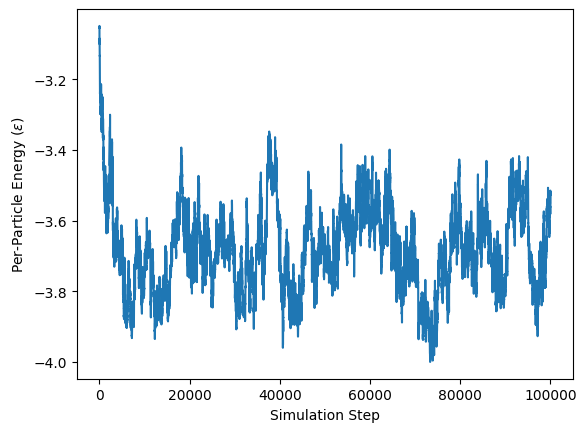

In [ ]:
d = Dynamics(32,4,1,100000,0.5)
d.run_dynamics()
d.plot_energy()

In [ ]:
for i in range(0,100000,10000):
  print(f'Start = {i}, nsamples = {autocorr1D(d.per_particle_energies[i:])}')

# I want to remove the equilibration, so I will start at step 10000.
# Step 10000 gives the greatest number of independent samples, not
# including steps during the equilibration.

Start = 0, nsamples = 31
Start = 10000, nsamples = 26
Start = 20000, nsamples = 22
Start = 30000, nsamples = 17
Start = 40000, nsamples = 7
Start = 50000, nsamples = 6
Start = 60000, nsamples = 12
Start = 70000, nsamples = 9
Start = 80000, nsamples = 9
Start = 90000, nsamples = 4


In [ ]:
start = 10000
nsamples = 26
nsteps = d.nsteps - start
decorr_spacing = (nsteps // nsamples) + 1 # + 1 to round up
independent_samples = []
for i in range(nsamples):
  value = d.per_particle_energies[start+i*decorr_spacing]
  independent_samples.append(value)

print(f'<energy>/N = {np.mean(independent_samples)} +/- {np.std(independent_samples)}')

<energy>/N = -3.7084670203492704 +/- 0.12554017766541453


# N/V = 0.5 T = 2.0

In [ ]:
# Benchmarking
import time

particle_density = 0.5
nsteps = 100
temperature = 2.0
N = np.arange(10,110,10)
L = (N/particle_density)**(1/3)

for i in range(len(N)):
  d = Dynamics(N[i],L[i],1,nsteps,temperature)
  t1 = time.time()
  d.run_dynamics()
  t2 = time.time()

  print(f'For N = {N[i]}, L = {L[i]}, efficiency = {nsteps/(t2-t1)} steps per second')
  print(f'For N = {N[i]}, L = {L[i]}, <energy>/N = {np.mean(d.per_particle_energies)}\n')

# In this case, I feel N = 30 gives too different of a result. I will try with N = 40
# to balance accuracy and computational efficiency.

For N = 10, L = 2.7144176165949063, efficiency = 1396.4302717747762 steps per second
For N = 10, L = 2.7144176165949063, <energy>/N = -1.795143024087152

For N = 20, L = 3.4199518933533937, efficiency = 388.85727450647727 steps per second
For N = 20, L = 3.4199518933533937, <energy>/N = -2.7563508003032946

For N = 30, L = 3.9148676411688634, efficiency = 216.6937126696704 steps per second
For N = 30, L = 3.9148676411688634, <energy>/N = -2.7195484943983645

For N = 40, L = 4.308869380063767, efficiency = 117.53010755158873 steps per second
For N = 40, L = 4.308869380063767, <energy>/N = -3.046452496535049

For N = 50, L = 4.641588833612778, efficiency = 71.8434139489106 steps per second
For N = 50, L = 4.641588833612778, <energy>/N = -3.2105296953182836

For N = 60, L = 4.93242414866094, efficiency = 42.46715261065972 steps per second
For N = 60, L = 4.93242414866094, <energy>/N = -3.09996834353384

For N = 70, L = 5.1924941018511035, efficiency = 26.042957582549228 steps per second
F

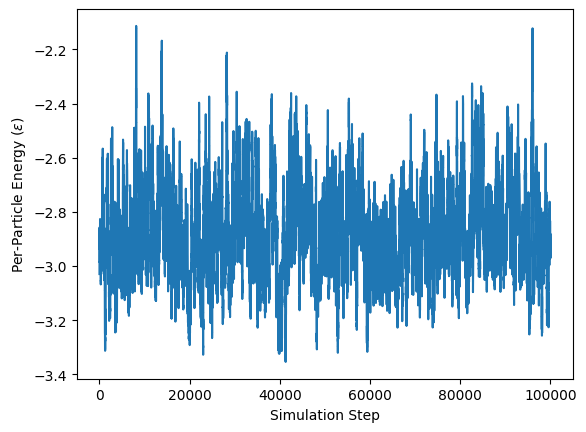

In [ ]:
particle_density = 0.5
N = 40
L = (N/particle_density)**(1/3)

d2 = Dynamics(N,L,1,100000,2.0)
d2.run_dynamics()
d2.plot_energy()

In [ ]:
for i in range(0,100000,10000):
  print(f'Start = {i}, nsamples = {autocorr1D(d2.per_particle_energies[i:])}')

# I don't see much cause to remove the "equilibration" here, so
# I will simply start from 0.

Start = 0, nsamples = 95
Start = 10000, nsamples = 88
Start = 20000, nsamples = 80
Start = 30000, nsamples = 70
Start = 40000, nsamples = 58
Start = 50000, nsamples = 60
Start = 60000, nsamples = 39
Start = 70000, nsamples = 67
Start = 80000, nsamples = 46
Start = 90000, nsamples = 30


In [ ]:
start = 0
nsamples = 95
nsteps = d2.nsteps - start
decorr_spacing = (nsteps // nsamples) + 1 # + 1 to round up
independent_samples = []
for i in range(nsamples):
  value = d2.per_particle_energies[start+i*decorr_spacing]
  independent_samples.append(value)

print(f'<energy>/N = {np.mean(independent_samples)} +/- {np.std(independent_samples)}')

<energy>/N = -2.8776304665458645 +/- 0.1590138098343878


# N/V = 0.7, T = 0.5

In [ ]:
# Benchmarking
import time

particle_density = 0.7
nsteps = 100
temperature = 0.5
N = np.arange(10,40,10)
L = (N/particle_density)**(1/3)

for i in range(len(N)):
  d3 = Dynamics(N[i],L[i],1,nsteps,temperature)
  t1 = time.time()
  d3.run_dynamics()
  t2 = time.time()

  print(f'For N = {N[i]}, L = {L[i]}, efficiency = {nsteps/(t2-t1)} steps per second')
  print(f'For N = {N[i]}, L = {L[i]}, <energy>/N = {np.mean(d3.per_particle_energies)}\n')

# Anything more than 30 takes ages to run, even just for 100 steps.
# I will opt for N = 30 here.

For N = 10, L = 2.4264275032025866, efficiency = 1520.3749551424025 steps per second
For N = 10, L = 2.4264275032025866, <energy>/N = -2.6740105658673445

For N = 20, L = 3.0571070873287987, efficiency = 453.3191820959467 steps per second
For N = 20, L = 3.0571070873287987, <energy>/N = -3.9801815463108188

For N = 30, L = 3.4995140238760083, efficiency = 171.80694297152039 steps per second
For N = 30, L = 3.4995140238760083, <energy>/N = -4.259178067033306



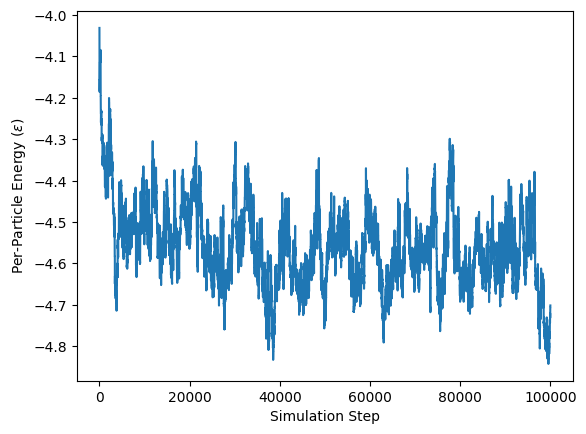

In [ ]:
particle_density = 0.7
N = 30
L = (N/particle_density)**(1/3)

d3 = Dynamics(N,L,1,100000,0.5)
d3.run_dynamics()
d3.plot_energy()

# I think the system may have found a new minimum near the end,
# but this already took so long to run. I think this is a sign
# that it's worth improving the efficiency of my code.

In [ ]:
for i in range(0,100000,10000):
  print(f'Start = {i}, nsamples = {autocorr1D(d3.per_particle_energies[i:])}')

# It is hard to say for sure, but I think I'll start from 30000,
# because it looks like the average may have moved down after that
# point.

Start = 0, nsamples = 41
Start = 10000, nsamples = 42
Start = 20000, nsamples = 49
Start = 30000, nsamples = 42
Start = 40000, nsamples = 41
Start = 50000, nsamples = 31
Start = 60000, nsamples = 28
Start = 70000, nsamples = 19
Start = 80000, nsamples = 6
Start = 90000, nsamples = 6


In [ ]:
start = 30000
nsamples = 42
nsteps = d3.nsteps - start
decorr_spacing = (nsteps // nsamples) + 1 # + 1 to round up
independent_samples = []
for i in range(nsamples):
  value = d3.per_particle_energies[start+i*decorr_spacing]
  independent_samples.append(value)

print(f'<energy>/N = {np.mean(independent_samples)} +/- {np.std(independent_samples)}')

<energy>/N = -4.582023735686647 +/- 0.08634272164873436


# N/V = 0.7, T = 2.0

In [ ]:
# Benchmarking
import time

particle_density = 0.7
nsteps = 100
temperature = 2.0
N = np.arange(10,40,10)
L = (N/particle_density)**(1/3)

for i in range(len(N)):
  d4 = Dynamics(N[i],L[i],1,nsteps,temperature)
  t1 = time.time()
  d4.run_dynamics()
  t2 = time.time()

  print(f'For N = {N[i]}, L = {L[i]}, efficiency = {nsteps/(t2-t1)} steps per second')
  print(f'For N = {N[i]}, L = {L[i]}, <energy>/N = {np.mean(d4.per_particle_energies)}\n')

# I've realized that the problem with my performance is my the code that checks for
# overlaps when the system is initialized. At high particle densities,
# there is a high probability that the system starts with many overlaps
# and it takes a long time to resolve this. If I had time to fix this, I would
# have the code evenly space the particles out at the start, and let
# it equilibrate from there.

For N = 10, L = 2.4264275032025866, efficiency = 1614.7900039654583 steps per second
For N = 10, L = 2.4264275032025866, <energy>/N = -2.0268943519620954

For N = 20, L = 3.0571070873287987, efficiency = 269.6188454670162 steps per second
For N = 20, L = 3.0571070873287987, <energy>/N = -3.375226324592157

For N = 30, L = 3.4995140238760083, efficiency = 170.59704230410523 steps per second
For N = 30, L = 3.4995140238760083, <energy>/N = -3.9377364189347923



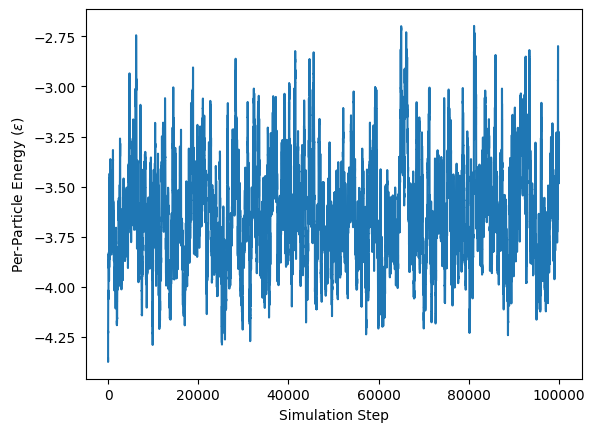

In [ ]:
particle_density = 0.7
N = 30
L = (N/particle_density)**(1/3)

d4 = Dynamics(N,L,1,100000,2.0)
d4.run_dynamics()
d4.plot_energy()

In [ ]:
for i in range(0,100000,10000):
  print(f'Start = {i}, nsamples = {autocorr1D(d4.per_particle_energies[i:])}')

# This time there might be a bit of equilibration time, so I will go from
# 10000 again

Start = 0, nsamples = 66
Start = 10000, nsamples = 64
Start = 20000, nsamples = 55
Start = 30000, nsamples = 47
Start = 40000, nsamples = 39
Start = 50000, nsamples = 32
Start = 60000, nsamples = 25
Start = 70000, nsamples = 16
Start = 80000, nsamples = 8
Start = 90000, nsamples = 4


In [ ]:
start = 10000
nsamples = 64
nsteps = d4.nsteps - start
decorr_spacing = (nsteps // nsamples) + 1 # + 1 to round up
independent_samples = []
for i in range(nsamples):
  value = d4.per_particle_energies[start+i*decorr_spacing]
  independent_samples.append(value)

print(f'<energy>/N = {np.mean(independent_samples)} +/- {np.std(independent_samples)}')

<energy>/N = -3.626159339664457 +/- 0.2895428378819504


# Updated Summary

Key takeaways from re-coding:

1. I should not have initialized my system by randomly generating coordinates for each point. The problem is that my code starts by checking for overlaps, and then randomly moving one of the overlapped particles to resolve this issue. I did this to speed up equilibration at the beginning of the simulation. This method works fine for particle densities around 0.5 N/V and below, but at high particle densities it makes system initialization extremely inefficient. What would work better would be to initialize the system by placing the particles on some equally spaced lattice, and then let the system evolve from there. The equilibration would still be quick, and I would avoid the problem of the system getting stuck at the initialization step. I didn't have time to make this change on this project, but it's definitely something I'll implement in future projects if applicable.

2. The autocorrelation function doesn't seem to be significantly affected by equilibration for this system. For almost all of my simulations, I achieved the maximum number of independent samples when including the entire trajectory. I still felt it was worth removing the equilibration in most cases, even if it meant sacrificing 1 or 2 extra samples, because I knew those first one or two samples would not be representative of the true mean. When you consider the ratio of independent samples to trajectory length, there certainly was an improvement after removing the equilibration step, but not enough of one for the absolute quantity of independent samples to be higher.

### Summary from Last Week

This system of mono-atomic particles interacting with the Lennard-Jones potential does an excellent job of modeling the equilibration of a gas based on its temperature and density. It goes beyond the ideal gas approximation by modeling the configurations taken on by interacting particles, and correcting figures such as the heat capacity in states where interaction potentials dominate entropy. Thanks to this, we observe phase transitions where molecules begin clustering together.

The system still has many limitations, of course. Our model assumes all particles are of uniform shape and size, monoatomic, and uncharged. I imagine accounting for charges would be as simple as incorporating a coulombic term into the calculation of the potential. Incorporating multiple different particle sizes, however, would be trickier, however, as it would require the interaction potential to depend not only on one sigma value, but on (I assume) the average between the sigma values of the two interacting particles. Finally, including bonded interactions for molecules would require a complete overhaul of both the potentials being used as well as the trial move scheme.

I learned a lot from working on this project, including very fundamental skills like object-oriented programming and utilizing the power of numpy arrays. Two topics specific to molecular simulation that stood out to me were the implementation of periodic boundary conditions and the used of reduced units.

In the past, I've always thought of periodic boundary conditions simply as a trick that's used to avoid unphysical scenarios. While this is true, in some respect, when researching how to implement PBC, I happened across an amazing blog post that described PBC as its own perfectly mathematically consistent coordinate system. (https://medium.com/@tom-mohr/periodic-boundaries-2883becbdd98). To utilize this coordinate system there are unique operators that have to be used in place of typical vector addition. Furthermore, there are applications beyond simulations in periodic systems like music and color theory. It reminded me a lot of when I first learned about spherical and hyperbolic geometry, and how that changes some of the fundamental rules of what is and isn't possible with math. It was very cool to see.

The reduced units are also very fascinating to me. I can completely see how and why they're useful, but I can also tell that I need quite a bit more practice with using them. I assume we'll continue to use them for the rest of this semester, so I look forward to improving!